In [1]:
#%matplotlib ipympl
import numpy as np
import sys

import astropy.io.fits as pyfits 
from astropy.table import Table, Column
from astropy.wcs import WCS
from astropy.coordinates import Angle
import astropy.units as u
from astropy.nddata import Cutout2D


from regions import Regions, PixCoord, TextPixelRegion, RegionVisual
from regions import CircleSkyRegion
from astropy.utils.data import get_pkg_data_filename

# setting path for mask_utils package
sys.path.append('..')

from mask_utils.code_utils import next_prime, ura_mura
from mask_utils.imaging_utils import  decode, decode_var, generate_bulk, get_openfraction,  get_skysign, get_skycoords, get_detimage_edges, get_detimage
from mask_utils.fits_utils import read_mask_bulk, write_mask_fits, read_fits_events
from mask_utils.image_utils import upscale, fshift

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
path = "F:/CodedMasks/Simulations/IROS No Bkg Smoothing/"
composed_file = path + "COMPOSED_OUTsky_IROS_CAM1A_CAM1B_TEST_testing.fits"

In [3]:
with pyfits.open(composed_file) as hdu_list:
    header_2 = hdu_list[2].header
    img = hdu_list[2].data

In [4]:
#reading WCS data
wcs = WCS(header_2)
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 266.4 -28.94 
CRPIX : 4180.0 4180.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.014108785893396 0.014108785893396 
NAXIS : 8359  8359

In [5]:
def plot_lb(img_f, img_b, wcs, fileout, spacing=15, regions=None):
    fig, ax = plt.subplots(subplot_kw=dict(projection=wcs), figsize=(7, 7))

    # Plot the image data
    ax.imshow(img_f, cmap=cm.gnuplot2, interpolation='none', origin='lower')
    ax.imshow(img_b, cmap=cm.gnuplot2, interpolation='none', origin='lower', alpha=0.175)

    # Explicitly remove the Equatorial (RA, Dec) tick labels and axes labels.
    # This targets the *primary* WCS axes.
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_axislabel('')
    ax.coords[1].set_axislabel('')

    # Also remove the major and minor tick *marks* themselves.
    ax.coords[0].set_ticks_visible(False)
    ax.coords[1].set_ticks_visible(False)

    # Add the Galactic Coordinate Grid (l, b)
    overlay = ax.get_coords_overlay('galactic')

    # Set the desired tick separation to 15 degrees
    #spacing = 15 * u.degree

    # Apply the spacing to Galactic Longitude (l) - overlay[0]
    overlay[0].set_major_formatter('d') # Use decimal degrees for formatting
    overlay[0].set_ticks(spacing=spacing * u.degree)
    overlay[0].set_axislabel('Galactic Longitude ($l$)', fontsize=16)
    overlay[0].set_ticklabel(fontsize=14)

    # Apply the spacing to Galactic Latitude (b) - overlay[1]
    overlay[1].set_major_formatter('d') # Use decimal degrees for formatting
    overlay[1].set_ticks(spacing=spacing * u.degree)
    overlay[1].set_axislabel('Galactic Latitude ($b$)', fontsize=16)
    overlay[1].set_ticklabel(fontsize=14)

    # The line below is also often the one that plots the RA/Dec grid lines,
    # which you should make sure is NOT present:
    # ax.grid(True, color='white', ls='solid') 
    # This overlay will now be the only one displaying ticks and labels.

    overlay.grid(color='gray', ls='dotted')
    overlay[0].set_axislabel('Galactic Longitude ($l$)')
    overlay[1].set_axislabel('Galactic Latitude ($b$)')

    if regions != None:
        visual = RegionVisual({'textangle': 45, 'color': 'white', 'fontsize':10})
        delta = PixCoord(x=0, y=20)
        for i, region in enumerate(regions):
            #patch = region.to_patch()
            #ax.add_patch(patch)
            text = region.meta['text']
            pixel_region = region.to_pixel(wcs)
            pixel_region.plot(ax=ax)
            reg = TextPixelRegion(center=pixel_region.center + delta, text=text, visual=visual)
            reg.plot(ax=ax)
           

    plt.savefig(fileout, format="png", bbox_inches="tight", dpi=300)

    plt.show()

In [6]:
#Optimizing SNR image for visualization
img_opt = np.pow(np.clip(img, a_min=3, a_max=50), 0.25)
img_bkg = np.pow(np.clip(img, a_min=0, a_max=50), 0.25) #this to re-add some low significance noise

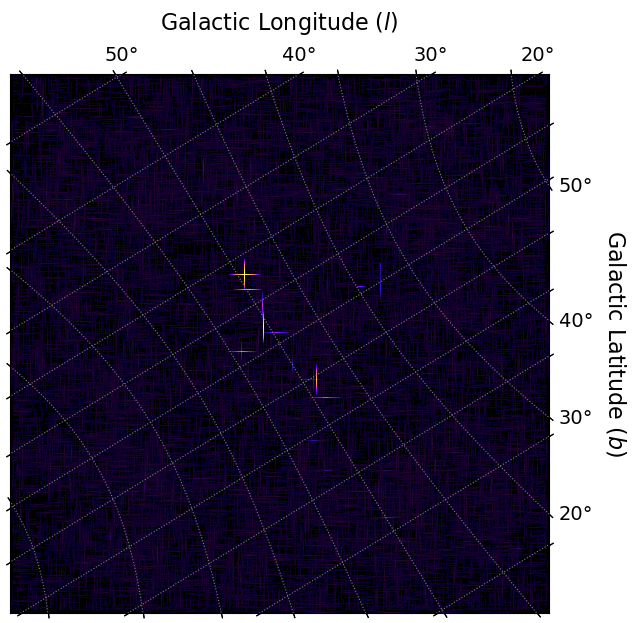

In [7]:
#Plotting full-scale composed image and saving it in png
plot_lb(img_opt, img_bkg, wcs,  "GC_composed_sky_image_sign.png", spacing=10)

In [8]:
#Generating a cut-out of the full-scale image ~centered on the GC
s = img.shape
position = ( (s[0] - 1) // 2 + 400, (s[1] - 1) // 2 - 100)
size = (3000, 3000)
cutout_opt = Cutout2D(img_opt, position, size, wcs=wcs)
cutout_bkg = Cutout2D(img_bkg, position, size, wcs=wcs)

In [9]:
#Reading DS9 region file
regions = Regions.read("F:/CodedMasks/Simulations/IROS No Bkg Smoothing/region.reg", format='ds9')

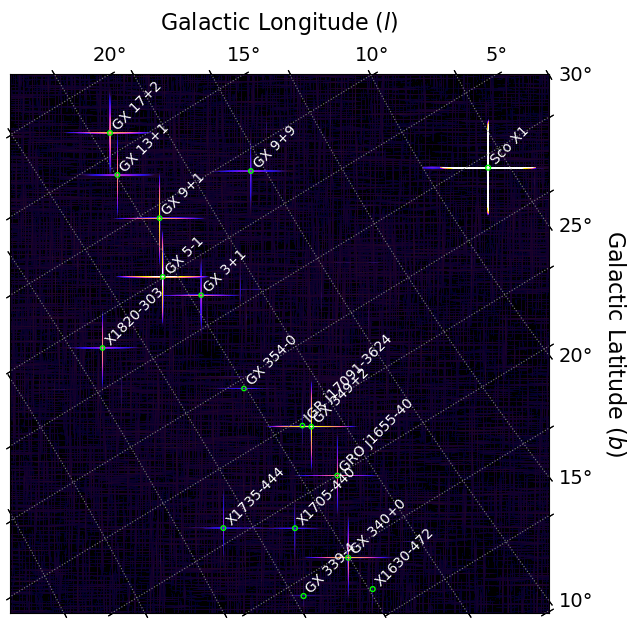

In [12]:
#Plotting cut.out composed image and saving it in png, adding source regions
plot_lb(cutout_opt.data, cutout_bkg.data, cutout_opt.wcs,  "GC_composed_sky_image_sign_zoom.png", spacing=5, regions=regions)

In [ ]:
for i, region in enumerate(regions):
    #region.plot(ax=ax)
    text = region.meta['text']
    pixel_region = region.to_pixel(wcs)
    print(pixel_region.center)
    #pixel_region.plot(ax=ax)